In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tushare as ts

tf.random.set_seed(8)

pro = ts.pro_api()
pro = ts.pro_api('107616fccaaf92567ab2299cf5b6ce3b5044922d11045bebe6664811')

df = ts.get_k_data('603259', start='2020-05-01', end='2021-12-31')
# df = pd.concat([data.DataReader(t, source, start, end) for t in tickers]).reset_index()
dates = df["date"]
df


本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


/opt/anaconda3/lib/python3.9/site-packages/tushare/stock/trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,


,date,open,close,high,low,volume,code
79,2020-05-06,58.509,58.646,59.093,57.849,178050.0,603259
80,2020-05-07,58.652,59.271,59.789,58.325,131756.0,603259
81,2020-05-08,59.503,60.646,60.855,59.105,137519.0,603259
82,2020-05-11,60.884,60.170,61.087,59.521,143412.0,603259
83,2020-05-12,60.146,62.134,62.134,59.706,162417.0,603259
...,...,...,...,...,...,...,...
481,2021-12-27,111.683,113.673,113.783,110.283,239177.0,603259
482,2021-12-28,112.683,118.583,119.463,112.083,438050.0,603259
483,2021-12-29,117.663,118.673,122.303,117.473,269864.0,603259
484,2021-12-30,118.673,119.493,120.983,116.363,173291.0,603259


In [2]:
cols = list(df)[1:3]
df_train = df[cols].astype(float)
df_train
# df_plt = df_train.tail(5000)
# df_plt.plot.line()

,open,close
79,58.509,58.646
80,58.652,59.271
81,59.503,60.646
82,60.884,60.170
83,60.146,62.134
...,...,...
481,111.683,113.673
482,112.683,118.583
483,117.663,118.673
484,118.673,119.493


In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
scaled = scaler.fit_transform(df_train)
scaled

array([[0.        , 0.        ],
       [0.00130031, 0.00574253],
       [0.0090385 , 0.0183761 ],
       [0.02159601, 0.01400259],
       [0.01488534, 0.03204792],
       [0.03242585, 0.05453109],
       [0.04887519, 0.05458622],
       [0.05926855, 0.04971655],
       [0.04995726, 0.0568281 ],
       [0.06219652, 0.06005311],
       [0.06056886, 0.0503689 ],
       [0.05666794, 0.05338258],
       [0.05191227, 0.02958553],
       [0.03047084, 0.03697272],
       [0.05347628, 0.05064454],
       [0.05391274, 0.022915  ],
       [0.02376016, 0.01335024],
       [0.01629476, 0.03423468],
       [0.04324659, 0.04834753],
       [0.04974812, 0.04900907],
       [0.05244876, 0.06803752],
       [0.07468129, 0.07687643],
       [0.07429938, 0.07971554],
       [0.08339244, 0.06233174],
       [0.06293306, 0.06539137],
       [0.06520632, 0.07618733],
       [0.07657264, 0.07604032],
       [0.06975285, 0.0905115 ],
       [0.08975758, 0.08568777],
       [0.09324022, 0.09832134],
       [0.

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(scaled, test_size=0.25, random_state=0)
print(train.shape)
print(test.shape)

(305, 2)
(102, 2)


In [5]:
days_future = 7
days_past = 14

train_X = []
train_y = []
test_X = []
test_y = []

for i in range(days_past, len(train) - days_future + 1):
    train_X.append(train[i - days_past:i, 0:train.shape[1]])
    train_y.append(train[i + days_future - 1:i + days_future, 0])
    
for i in range(days_past, len(test) - days_future + 1):
    test_X.append(test[i - days_past:i, 0:train.shape[1]])
    test_y.append(test[i + days_future - 1:i + days_future, 0])
    
train_X, train_y, test_X, test_y = np.array(train_X), np.array(train_y), np.array(test_X), np.array(test_y)
    
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(285, 14, 2)
(285, 1)
(82, 14, 2)
(82, 1)


In [6]:
# To solve the problem: To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
# Don't know why, just copy this solution of CSDN
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [7]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Layer
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(64, activation="relu", input_shape = (train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units = 64, return_sequences = True))
# model.add(Dropout(0.2))
# model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False, dropout=0.5))
model.add(Dense(1))
model.compile(optimizer = "adam", loss = "mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17152     
                                                                 
 lstm_1 (LSTM)               (None, 14, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 62,625
Trainable params: 62,625
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(train_X, train_y, epochs=10, batch_size=64, validation_data=(test_X, test_y), verbose=1)

Epoch 1/10
5/5 [==============================] - 8s 451ms/step - loss: 0.2085 - val_loss: 0.0919
Epoch 2/10
5/5 [==============================] - 0s 85ms/step - loss: 0.0811 - val_loss: 0.1073
Epoch 3/10
5/5 [==============================] - 0s 74ms/step - loss: 0.0778 - val_loss: 0.0762
Epoch 4/10
5/5 [==============================] - 0s 68ms/step - loss: 0.0699 - val_loss: 0.0802
Epoch 5/10
5/5 [==============================] - 0s 59ms/step - loss: 0.0677 - val_loss: 0.0759
Epoch 6/10
5/5 [==============================] - 0s 58ms/step - loss: 0.0647 - val_loss: 0.0801
Epoch 7/10
5/5 [==============================] - 0s 65ms/step - loss: 0.0655 - val_loss: 0.0777
Epoch 8/10
5/5 [==============================] - 0s 62ms/step - loss: 0.0648 - val_loss: 0.0761
Epoch 9/10
5/5 [==============================] - 0s 62ms/step - loss: 0.0676 - val_loss: 0.0760
Epoch 10/10
5/5 [==============================] - 0s 77ms/step - loss: 0.0641 - val_loss: 0.0780


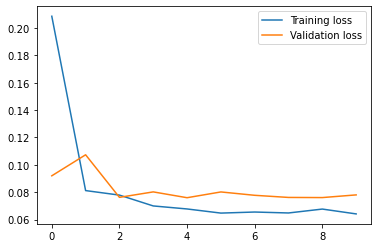

In [9]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [10]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
future = days_future + days_past

# days_past?
prediction_dates = pd.date_range(list(dates)[-future], periods=future, freq=us_bd).tolist()

prediction = model.predict(train_X[-future:])

1/1 [==============================] - 2s 2s/step


In [11]:
prediction_copies = np.repeat(prediction, df_train.shape[1], axis=-1)
y_forecast = scaler.inverse_transform(prediction_copies)[:,0]

In [12]:
forecast_dates = []
for time_i in prediction_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'open':y_forecast})
df_forecast['date']=pd.to_datetime(df_forecast['date'])

In [13]:
original = df[['date', 'open']]
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2021-8-1']

/var/folders/5_/bb05t_s57j12tjmc9s6_yg_r0000gn/T/ipykernel_49019/740320029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(original['date'])


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='open'>

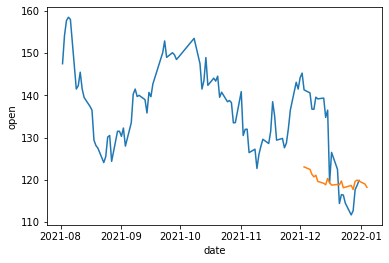

In [14]:
import seaborn as sns

sns.lineplot(original['date'], original['open'])
sns.lineplot(df_forecast['date'], df_forecast['open'])

In [127]:
result = pd.concat([df,df_forecast], axis=0, join="outer")
result.to_csv("603259_YMKD.csv")

In [15]:
df.to_csv("603259_YMKD.csv")